In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import sparse


%matplotlib inline

In [2]:
import geopy.distance
######codes for loading historical original airquality and weather data
def get_df_in_range(df,start,end,attr_name):
    return df.loc[(df[attr_name] >= start) & (df[attr_name] < end)]

def load_old_all(start_17='2017-02-14 00:00:00',end_17='2017-07-01 00:00:00',start_18='2018-02-01 00:00:00',end_18='2018-04-01 00:00:00'):
    '''
        Load all data needed in 2017.02.14-2017.06.30 & 2018.02.01 - 2018.03.31
    '''
    aq_year_df = pd.read_csv('./data/airQuality_201701-201801.csv')
    grid_year_df = pd.read_csv('./data/gridWeather_201701-201803.csv')
    ob_year_df = pd.read_csv('./data/observedWeather_201701-201801.csv')

    aq_year_needed = get_df_in_range(aq_year_df,start_17, end_17,'utc_time')
    grid_year_needed = get_df_in_range(grid_year_df,start_17, end_17,'utc_time')
    ob_year_needed = get_df_in_range(ob_year_df,start_17, end_17,'utc_time')

    aq_year_df1 = pd.read_csv('./data/airQuality_201802-201803.csv')
    ob_year_df1 = pd.read_csv('./data/observedWeather_201802-201803.csv')
    grid_year_df1 = get_df_in_range(grid_year_df,start_18, end_18,'utc_time')
    aq_year_df1 = get_df_in_range(aq_year_df1,start_18, end_18,'utc_time')
    ob_year_df1 = get_df_in_range(ob_year_df1,start_18,end_18,'utc_time')

    aq_old = pd.concat([aq_year_needed,aq_year_df1],axis=0)
    ob_old = pd.concat([ob_year_needed,ob_year_df1],axis=0)
    grid_old = pd.concat([grid_year_needed,grid_year_df1],axis=0)

    ob_old = ob_old.drop(['latitude','longitude'],axis=1)
    grid_old['station_id'] = grid_old['stationName']
    grid_old = grid_old.drop(['stationName'],axis=1)
    
    #load geo df
    aq_geo = pd.read_csv('./data/aq_geo.csv')
    ob_geo = pd.read_csv('./data/observeWeather_geo.csv')
    
    aq_old = aq_old.merge(aq_geo,how='left',left_on=['stationId'],right_on=['station_id'])
    aq_old  = aq_old.drop(['stationId'],axis=1)
    
    ob_old = ob_old.merge(ob_geo[['latitude','longitude','station_id']],how='left',on='station_id')

    return aq_old,ob_old,grid_old
	
######code for filling the weather info
def get_aq_w_dist():
    aq_geo = pd.read_csv('./data/aq_geo.csv')[['station_id','latitude','longitude']].values
    obs_geo = pd.read_csv('./data/observeWeather_geo.csv')[['station_id','latitude','longitude']].values
    grid_geo = pd.read_csv('./data/Beijing_grid_weather_station.csv',names=['station_id','latitude','longitude'])[['station_id','latitude','longitude']].values
    
    aq_start = []
    w_end = []
    dist_list = []
    for i in range(aq_geo.shape[0]):
        for j in range(obs_geo.shape[0]):
            aq_start.append(aq_geo[i][0])
            w_end.append(obs_geo[j][0])
            dist_list.append(geopy.distance.vincenty((aq_geo[i][1],aq_geo[i][2]),(obs_geo[j][1],obs_geo[j][2])).km)

        for k in range(grid_geo.shape[0]):
            aq_start.append(aq_geo[i][0])
            w_end.append(grid_geo[k][0])
            dist_list.append(geopy.distance.vincenty((aq_geo[i][1],aq_geo[i][2]),(grid_geo[k][1],grid_geo[k][2])).km)
    aq_w_dist_df = pd.DataFrame({'aq_start':aq_start,'w_end':w_end,'dist':dist_list})
    aq_w_dist_df = aq_w_dist_df.sort_values(by=['aq_start','dist'])
    
    #get top 3 nearest station for each aq_station
    top3_dict = {}
    aq_w_grouped = aq_w_dist_df.groupby('aq_start')
    for key,group in aq_w_grouped:
        top3_dict[key] = group['w_end'].values[:3]
    aq_group = aq_w_dist_df.groupby('aq_start',as_index=False)
    return aq_group

def clean_weather(df):
    df = df.loc[df.humidity < 100]
    df = df.loc[df.pressure < 3000]
    df = df.loc[df.temperature < 60]
    return df
	
def add_nearest_weather(aq_df,weather_all,aq_w_dist_group,level,time_column,weather_attrs = [ 'humidity', 'pressure', 'temperature']):
    '''
        This function find the nearesr weather station for the air quality data
    '''
    if level == 0:
        print("level 0 before fill: ",aq_df.shape[0]) 	
        new_df1 = pd.merge(aq_df, aq_w_dist_group.nth(0),  how='left', left_on=['station_id'], right_on = ['aq_start'])
        aq_all = pd.merge(new_df1, weather_all[weather_attrs+['station_id',time_column]],  how='left', left_on=['w_end',time_column], right_on = ['station_id',time_column])
        print("level 1 after fill: ",aq_all.shape[0])
        return aq_all
    else:
        #print("level"+str(level)+" before fill: ",aq_df.shape[0])
        aq_na_df = aq_df[aq_df[weather_attrs].isnull().any(axis=1)]
        aq_not_na_df = aq_df[~aq_df[weather_attrs].isnull().any(axis=1)]
        print("not na vs na:",aq_not_na_df.shape[0],aq_na_df.shape[0])    
        to_drop = ['aq_start','dist', 'w_end', 'id_y', 'station_id_y']+weather_attrs
        real_drop = [x for x in to_drop if x in aq_na_df.columns]    
        aq_na_df = aq_na_df.drop(real_drop,axis=1)
        old_columns = aq_na_df.columns
        new_columns = [x[:-2] if x.endswith('_x') else x for x in old_columns]

        aq_na_df.columns = new_columns 
        
        new_df2 = pd.merge(aq_na_df,aq_w_dist_group.nth(level),  how='left', left_on=['station_id'], right_on = ['aq_start'])
        aq_na_df_new = pd.merge(new_df2, weather_all[weather_attrs+['station_id',time_column]],  how='left', left_on=['w_end',time_column], right_on = ['station_id',time_column])
        aq_new_all = pd.concat([aq_not_na_df,aq_na_df_new],axis=0)
        #print("level"+str(level)+" after fill: ",aq_new_all.shape[0])
        #print(aq_not_na_df.columns)
        #print(aq_na_df_new.columns)
        return aq_new_all
		
def fill_weather_gap(aq_df,weather_df,levels,time_column,weather_attrs=['humidity','pressure','temperature']):
    aq_group = get_aq_w_dist()
    aq_all = add_nearest_weather(aq_df,weather_df,aq_group,0,time_column,weather_attrs)
    for i in range(1,levels):
        print("Level "+str(i)+" #null before",aq_all[weather_attrs].isnull().any(axis=1).sum())
        aq_all = add_nearest_weather(aq_all,weather_df,aq_group,i,time_column,weather_attrs)
        print("After: ",aq_all[weather_attrs].isnull().any(axis=1).sum())
    aq_all['station_id'] = aq_all['station_id_x']
    aq_all = aq_all.drop(['station_id_x','station_id_y','aq_start'],axis=1)
    return aq_all

In [3]:
#load the historial data in 2017 and 2018
#here I use data from 2017-02-14-2017-07-01 and 2018-02-01 2018-04-01
weather_used_old = ['pressure','temperature','humidity','wind_direction','wind_speed/kph']
aq_old,ob_old,grid_old = load_old_all(start_17='2017-03-1 00:00:00',end_17='2017-05-03 12:00:00',start_18='2018-03-01 00:00:00',end_18='2018-04-01 00:00:00')

#prepare weather data
weather_old_all = pd.concat([ob_old,grid_old]).reset_index()
weather_old_all = clean_weather(weather_old_all)
weather_old_all = weather_old_all.drop(['latitude','longitude'],axis=1)
weather_old_all = weather_old_all.drop_duplicates(subset=['utc_time','station_id'])

#add time columns to airQuality data
#levels is the number of nearest weather station to search
#time_column is the name of the time column
print("before fill: ",aq_old.shape[0])
aq_old_all = fill_weather_gap(aq_df=aq_old,weather_df=weather_old_all,levels = 3,time_column = 'utc_time',weather_attrs=weather_used_old)
print("after fill: ",aq_old_all.shape[0])

aq_old_all['timestamp'] = pd.to_datetime(aq_old_all['utc_time'])
aq_old_all['year'] = aq_old_all['timestamp'].dt.year
aq_old_all['month'] = aq_old_all['timestamp'].dt.month
aq_old_all['day'] = aq_old_all['timestamp'].dt.day
aq_old_all['hour'] = aq_old_all['timestamp'].dt.hour


before fill:  66640
level 0 before fill:  66640
level 1 after fill:  66640
Level 1 #null before 23488
not na vs na: 43152 23488
After:  3710
Level 2 #null before 3710
not na vs na: 62930 3710
After:  3710
after fill:  66640


In [4]:
def generate(dataframe,start='2018-05-01 00:00:00',end='2018-05-02 22:00:00'):
    stations = dataframe['station_id'].unique()
    columns = list(dataframe.columns)
    whole=None
    for i in list(stations):
        #print(i)
        section = pd.DataFrame({'time':pd.date_range(start=start, end=end, freq='1h')})
        #print(section)
        section['time']=section['time'].apply(lambda x: str(x))
        for k in columns:
            if k == 'station_id':
                section[k] = i
            elif k == 'time':
                continue
            else:
                section[k]=0               
        try:
            whole = whole.append(section)
        except:
            whole = section
        #print(whole)
    return whole.sort_values(by=['time'])

In [5]:
weather_used = ['pressure','temperature','humidity','wind_direction','wind_speed']
aq_df4 = pd.read_csv('./data/aiqQuality_201804.csv')
grid_df4 = pd.read_csv('./data/gridWeather_201804.csv')
ob_df4 = pd.read_csv('./data/observedWeather_201804.csv')

test_grid = pd.read_csv('data/gridWeather_20180501-20180502.csv')
test_weather = pd.read_csv('data/observedWeather_20180501-20180502.csv')
airq_5= generate(aq_df4,'2018-05-01 00:00:00','2018-05-02 23:00:00')
print("aq5 before:",airq_5.shape)
gt = pd.read_csv('data/external_0501-0502.csv')
gt = gt.sort_values(by='time').reset_index(drop=True)
airq_5 = airq_5[['time','station_id']].merge(gt,how='left',on=['station_id','time'])
print("aq5 after:",airq_5.shape)
aq_df4 = aq_df4.append(airq_5)



#prepare weather data
weather_all = pd.concat([ob_df4,grid_df4,test_grid,test_weather]).reset_index()
weather_all = clean_weather(weather_all)

aq5 before: (1680, 9)
aq5 after: (1680, 9)


In [6]:
#add time columns to airQuality data
#levels is the number of nearest weather station to search
#time_column is the name of the time column
aq_all = fill_weather_gap(aq_df=aq_df4,weather_df=weather_all,levels = 5,time_column = 'time',weather_attrs=weather_used)


aq_all['timestamp'] = pd.to_datetime(aq_all['time'])
aq_all['year'] = aq_all['timestamp'].dt.year
aq_all['month'] = aq_all['timestamp'].dt.month
aq_all['day'] = aq_all['timestamp'].dt.day
aq_all['hour'] = aq_all['timestamp'].dt.hour

level 0 before fill:  24990
level 1 after fill:  24990
Level 1 #null before 375
not na vs na: 24615 375
After:  104
Level 2 #null before 104
not na vs na: 24886 104
After:  66
Level 3 #null before 66
not na vs na: 24924 66
After:  48
Level 4 #null before 48
not na vs na: 24942 48
After:  30


In [7]:
aq_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24990 entries, 0 to 47
Data columns (total 21 columns):
CO_Concentration      23885 non-null float64
NO2_Concentration     23887 non-null float64
O3_Concentration      23735 non-null float64
PM10_Concentration    19870 non-null float64
PM25_Concentration    23663 non-null float64
SO2_Concentration     23907 non-null float64
id                    24990 non-null int64
time                  24990 non-null object
dist                  24990 non-null float64
w_end                 24990 non-null object
pressure              24960 non-null float64
temperature           24960 non-null float64
humidity              24960 non-null float64
wind_direction        24960 non-null float64
wind_speed            24960 non-null float64
station_id            24990 non-null object
timestamp             24990 non-null datetime64[ns]
year                  24990 non-null int64
month                 24990 non-null int64
day                   24990 non-null int6

In [8]:
#adjust different columns names
old_columns = aq_all.columns
new_columns = [x[:-14] if x.endswith('_Concentration') else x for x in old_columns]
aq_all.columns = new_columns

#add geo info of the air quality stations for nearest weather station searching
aq_geo = pd.read_csv('./data/aq_geo.csv')
aq_all = aq_all.merge(aq_geo,how='left',on='station_id')
aq_all = aq_all.drop(['id'],axis=1)

In [9]:
#update the name of historical data
old_columns = list(aq_old_all.columns)
old_columns[old_columns.index('PM2.5')] = 'PM25'
old_columns[old_columns.index('wind_speed/kph')] = 'wind_speed'
old_columns[old_columns.index('utc_time')] = 'time'
aq_old_all.columns = old_columns

In [10]:
#seperate data into 2017 and 2018
aq_2017 = aq_old_all.loc[aq_old_all.year == 2017]
aq_2018_old = aq_old_all.loc[aq_old_all.year == 2018]
aq_2018 = pd.concat([aq_2018_old,aq_all],axis=0)

In [11]:
aq_2017['date_h'] = aq_2017['timestamp'].apply(lambda x: (x.timetuple().tm_yday)*24 + x.hour)

aq_2018['date_h'] = aq_2018['timestamp'].apply(lambda x: (x.timetuple().tm_yday)*24+(x.hour) )

/home/xiaowen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [12]:
aq_2018.head()

,CO,NO2,O3,PM10,PM25,SO2,day,dist,hour,humidity,...,station_id_int,station_type_id,temperature,time,timestamp,w_end,wind_direction,wind_speed,year,date_h
40880,0.4,22.0,58.0,47.0,9.0,9.0,1,2.014976,0,15.25,...,4,0,0.37,2018-03-01 00:00:00,2018-03-01 00:00:00,beijing_grid_304,352.95,7.03,2018,1440
40881,0.4,19.0,61.0,47.0,14.0,8.0,1,2.014976,1,13.85,...,4,0,1.55,2018-03-01 01:00:00,2018-03-01 01:00:00,beijing_grid_304,339.04,7.03,2018,1441
40882,0.4,NaN,61.0,38.0,11.0,NaN,1,2.014976,2,12.44,...,4,0,2.73,2018-03-01 02:00:00,2018-03-01 02:00:00,beijing_grid_304,325.89,7.43,2018,1442
40883,0.3,9.0,NaN,33.0,4.0,5.0,1,2.014976,3,11.04,...,4,0,3.92,2018-03-01 03:00:00,2018-03-01 03:00:00,beijing_grid_304,314.60,8.17,2018,1443
40884,0.2,6.0,82.0,18.0,NaN,3.0,1,2.014976,4,10.46,...,4,0,4.99,2018-03-01 04:00:00,2018-03-01 04:00:00,beijing_grid_304,275.96,5.35,2018,1444


In [13]:
weather_old_all['time'] = weather_old_all['utc_time']
weather_all_20172018 = pd.concat([weather_old_all[['station_id','time','weather']],weather_all[['station_id','time','weather']]],axis=0)
old_columns = list(weather_all_20172018.columns)
old_columns[old_columns.index('station_id')] = 'w_end'
weather_all_20172018.columns = old_columns

In [14]:
aq_2018 = aq_2018.merge(weather_all_20172018,how='left',on=['w_end','time'])

In [15]:
aq_2017 = aq_2017.merge(weather_all_20172018,how='left',on=['w_end','time'])

In [16]:
aq_2018.weather.unique()

array([nan, 'Hail', 'Sleet', 'Sunny/clear', 'HAZE', 'CLEAR_DAY',
       'PARTLY_CLOUDY_DAY', 'PARTLY_CLOUDY_NIGHT', 'CLOUDY', 'CLEAR_NIGHT',
       'Cloudy', 'Thundershower', 'WIND', 'RAIN', 'Overcast', 'Light Rain',
       'SNOW', 'Rain'], dtype=object)

In [17]:
badw_2018df = aq_2018.loc[aq_2018.weather.isin(['Sleet','HAZE'])]
notbadw_2018df = aq_2018.loc[~aq_2018.weather.isin(['Sleet','HAZE'])]

In [18]:
print(badw_2018df.PM10.describe())
print(notbadw_2018df.PM10.describe())

count     853.000000
mean      300.978898
std       264.103759
min         6.000000
25%       195.000000
50%       251.000000
75%       310.000000
max      2835.000000
Name: PM10, dtype: float64
count    37320.000000
mean       134.690648
std        156.666530
min          6.000000
25%         63.000000
50%        103.000000
75%        169.000000
max       3280.000000
Name: PM10, dtype: float64


2017 ['2017-04-17 07:00:00' '2017-04-12 13:00:00' '2017-03-18 19:00:00']
2018 [['2018-04-05 16:00:00' 'CLEAR_NIGHT' 4.5 3.5328170682068603]
 ['2018-04-05 15:00:00' 'CLEAR_NIGHT' 7.0 3.5328170682068603]
 ['2018-04-05 17:00:00' 'HAZE' 4.4 3.5328170682068603]]
0
dongsi_aq


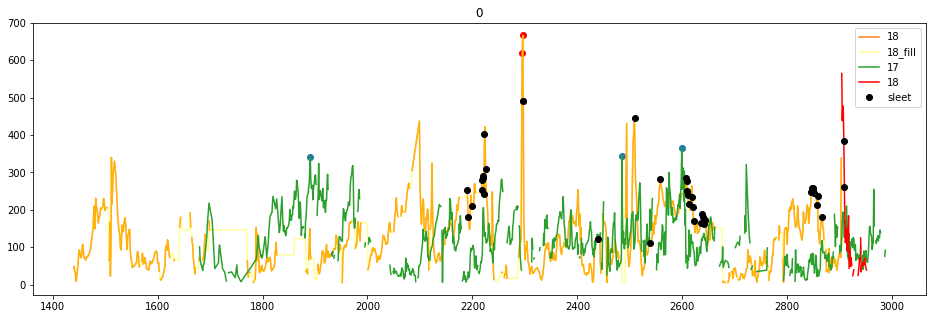

2017 ['2017-04-17 12:00:00' '2017-04-17 07:00:00' '2017-04-16 22:00:00']
2018 [['2018-04-29 05:00:00' 'PARTLY_CLOUDY_DAY' 25.0 1.6657617351883103]
 ['2018-04-05 16:00:00' 'CLEAR_NIGHT' 4.5 1.6657617351883103]
 ['2018-04-05 15:00:00' 'CLEAR_NIGHT' 7.0 1.6657617351883103]]
0
tiantan_aq


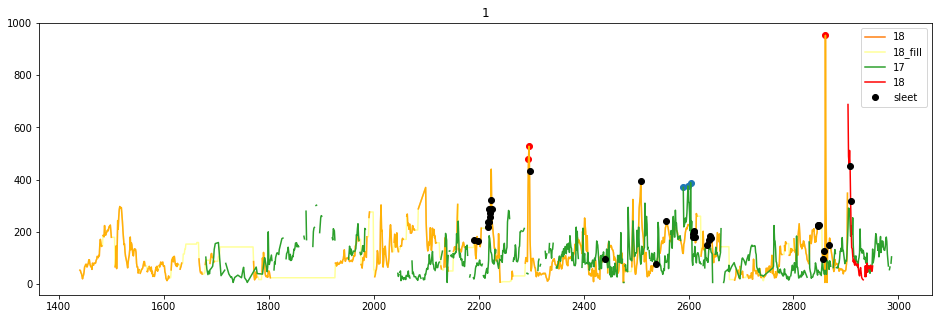

2017 ['2017-04-17 07:00:00' '2017-04-12 13:00:00' '2017-04-17 09:00:00']
2018 [['2018-03-28 11:00:00' 'Sunny/clear' 19.5 7.650376843567493]
 ['2018-04-02 16:00:00' 'PARTLY_CLOUDY_NIGHT' 14.0 4.635415799187261]
 ['2018-04-14 13:00:00' 'CLEAR_NIGHT' 16.0 4.635415799187261]]
0
guanyuan_aq


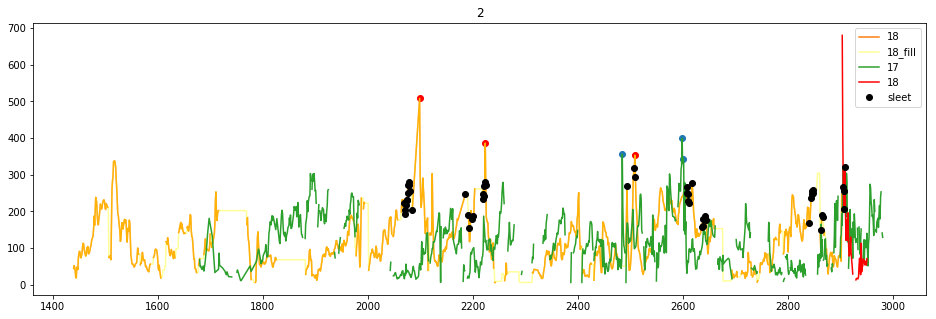

2017 ['2017-04-17 07:00:00' '2017-04-17 09:00:00' '2017-04-30 02:00:00']
2018 [['2018-04-05 16:00:00' 'CLEAR_NIGHT' 4.5 4.777265692603123]
 ['2018-04-02 16:00:00' 'CLOUDY' 14.0 4.777265692603123]
 ['2018-04-14 22:00:00' 'CLEAR_DAY' 6.0 4.777265692603123]]
0
wanshouxigong_aq


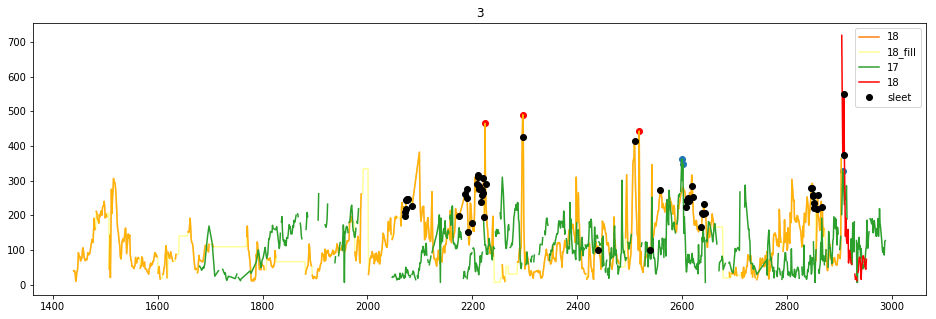

2017 ['2017-04-16 07:00:00' '2017-04-17 07:00:00' '2017-04-17 08:00:00']
2018 [['2018-04-05 15:00:00' 'HAZE' 7.0 2.01497623391867]
 ['2018-04-05 16:00:00' 'CLEAR_NIGHT' 4.5 2.01497623391867]
 ['2018-03-28 11:00:00' nan nan 9.020908407548172]]
0
aotizhongxin_aq


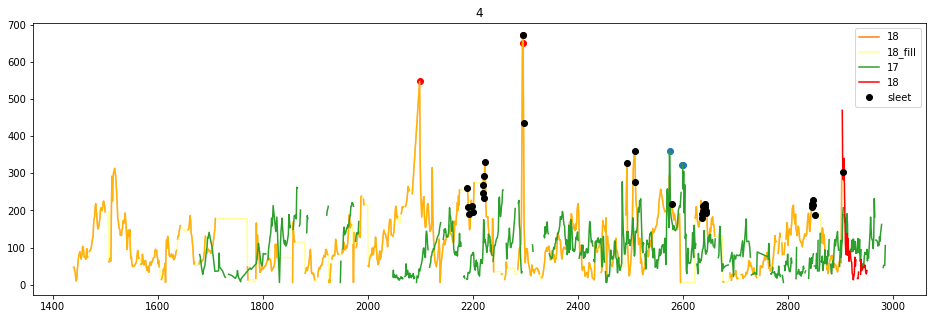

2017 ['2017-04-17 08:00:00' '2017-04-17 12:00:00' '2017-04-17 07:00:00']
2018 [['2018-04-05 15:00:00' 'Hail' 7.6 3.8145653943195272]
 ['2018-04-05 16:00:00' 'Hail' 6.7 3.8145653943195272]
 ['2018-04-13 22:00:00' 'CLEAR_DAY' 10.0 5.291045681596477]]
0
nongzhanguan_aq


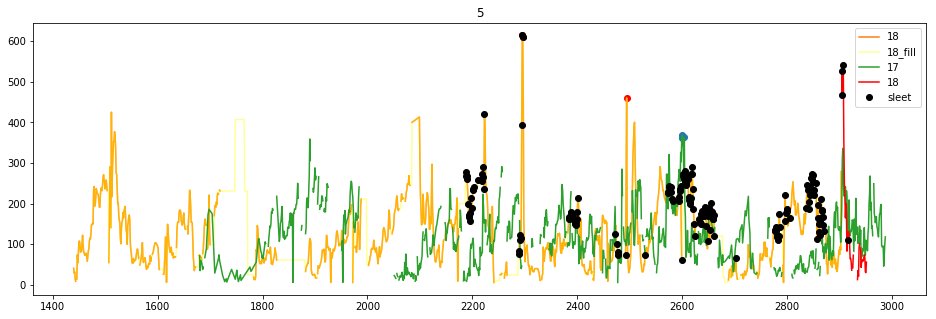

2017 ['2017-04-17 07:00:00' '2017-04-17 05:00:00' '2017-04-17 09:00:00']
2018 [['2018-04-05 16:00:00' 'Sunny/clear' 6.4 0.3037429368585245]
 ['2018-04-05 15:00:00' 'Sunny/clear' 7.0 0.3037429368585245]
 ['2018-03-28 11:00:00' nan nan 7.568883138461071]]
0
wanliu_aq


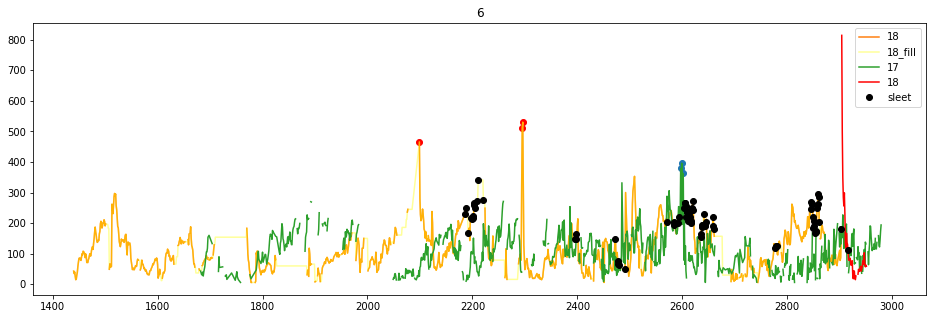

2017 ['2017-04-30 04:00:00' '2017-04-30 04:00:00' '2017-04-30 09:00:00']
2018 [['2018-03-30 21:00:00' nan nan 10.236548873607006]
 ['2018-03-30 20:00:00' nan nan 10.236548873607006]
 ['2018-04-13 20:00:00' 'CLEAR_NIGHT' 8.9 2.4796591806879906]]
0
beibuxinqu_aq


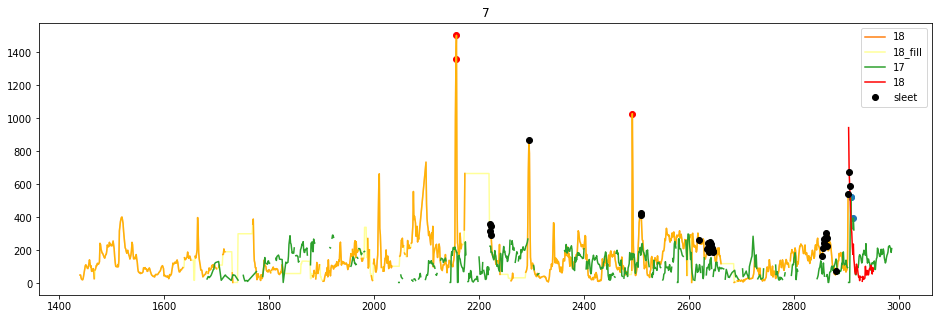

2017 ['2017-04-12 14:00:00' '2017-03-22 05:00:00' '2017-04-17 10:00:00']
2018 [['2018-03-01 00:00:00' nan -0.27 0.6376658802053164]
 ['2018-03-01 01:00:00' nan 1.01 0.6376658802053164]
 ['2018-03-01 02:00:00' nan 2.3 0.6376658802053164]]
0
zhiwuyuan_aq


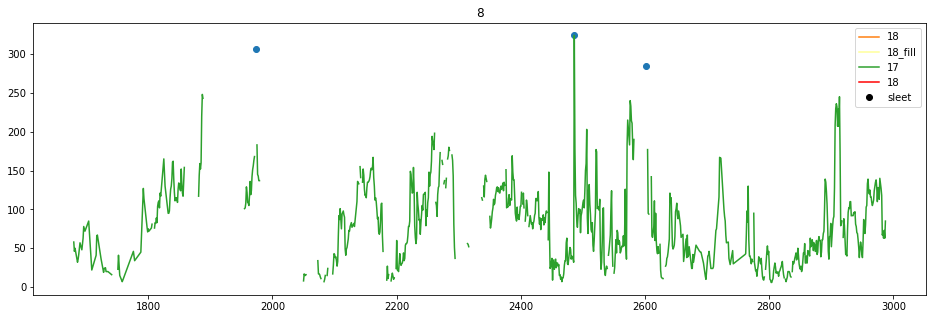

2017 ['2017-04-17 07:00:00' '2017-04-17 09:00:00' '2017-04-17 08:00:00']
2018 [['2018-04-19 14:00:00' 'Sunny/clear' 21.6 2.9962851777823944]
 ['2018-04-19 15:00:00' 'Sunny/clear' 21.0 2.9962851777823944]
 ['2018-04-02 16:00:00' 'Sunny/clear' 20.9 2.9962851777823944]]
0
fengtaihuayuan_aq


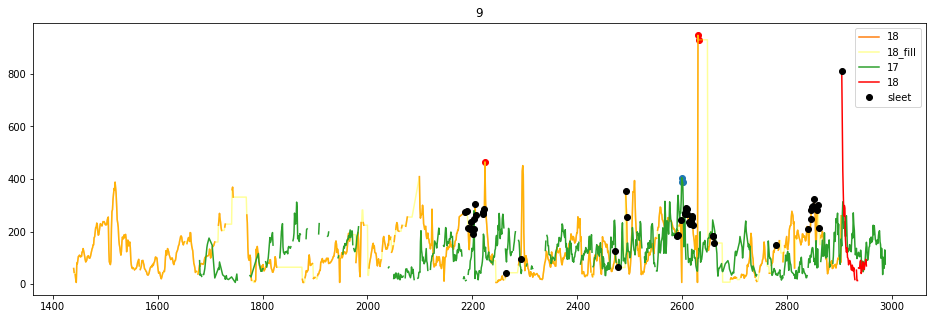

2017 ['2017-03-17 17:00:00' '2017-04-17 06:00:00' '2017-04-17 08:00:00']
2018 [['2018-04-13 20:00:00' 'CLEAR_NIGHT' 8.78 4.755580821092359]
 ['2018-04-02 16:00:00' 'HAZE' 14.0 4.755580821092359]
 ['2018-04-02 17:00:00' 'HAZE' 14.0 4.755580821092359]]
0
yungang_aq


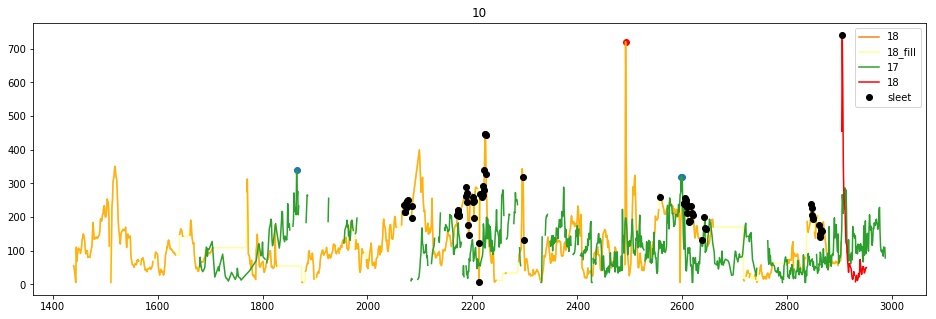

2017 ['2017-03-19 01:00:00' '2017-04-17 07:00:00' '2017-04-02 17:00:00']
2018 [['2018-04-13 20:00:00' 'CLEAR_NIGHT' 10.01 2.0707943483570737]
 ['2018-04-05 16:00:00' 'HAZE' 4.5 2.0707943483570737]
 ['2018-03-28 11:00:00' 'Sunny/clear' 19.3 3.748647526122348]]
0
gucheng_aq


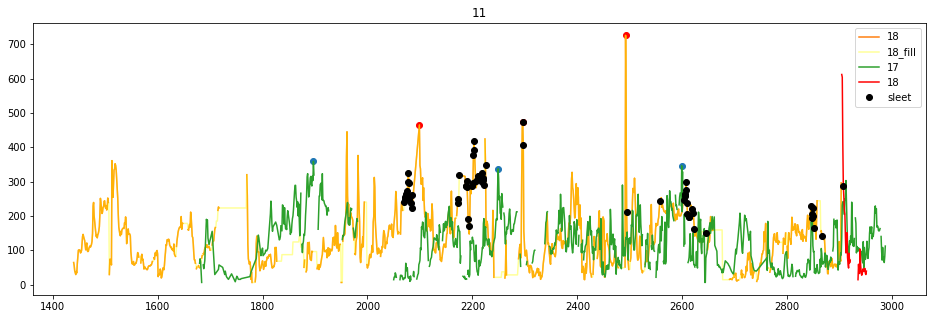

2017 ['2017-04-17 12:00:00' '2017-04-17 08:00:00' '2017-03-19 00:00:00']
2018 [['2018-04-02 16:00:00' 'CLOUDY' 14.0 5.592239242666751]
 ['2018-03-28 11:00:00' nan nan 7.140314579879876]
 ['2018-03-14 19:00:00' nan 12.51 5.592239242666751]]
1
fangshan_aq


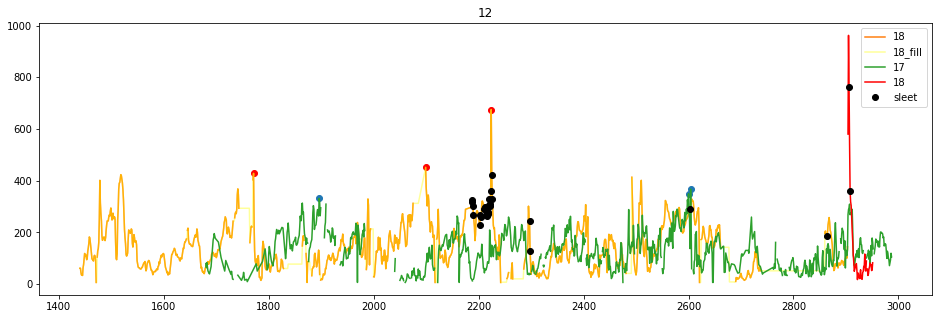

2017 ['2017-04-17 13:00:00' '2017-04-12 13:00:00' '2017-04-17 07:00:00']
2018 [['2018-03-30 03:00:00' nan nan 8.471610874912537]
 ['2018-04-02 16:00:00' 'CLOUDY' 14.0 2.0277467407226735]
 ['2018-04-02 15:00:00' 'HAZE' 18.0 2.0277467407226735]]
1
daxing_aq


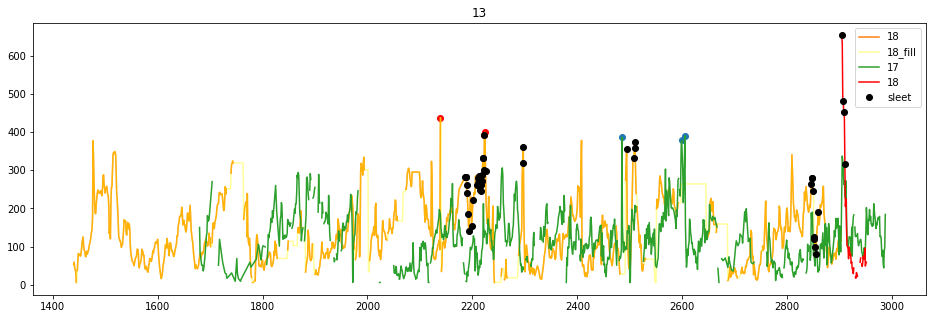

2017 ['2017-03-17 20:00:00' '2017-04-17 07:00:00' '2017-03-18 17:00:00']
2018 [['2018-04-05 17:00:00' 'HAZE' 4.4 0.7564796974825206]
 ['2018-04-05 16:00:00' 'HAZE' 4.5 0.7564796974825206]
 ['2018-04-13 22:00:00' 'CLEAR_DAY' 10.0 0.7564796974825206]]
1
yizhuang_aq


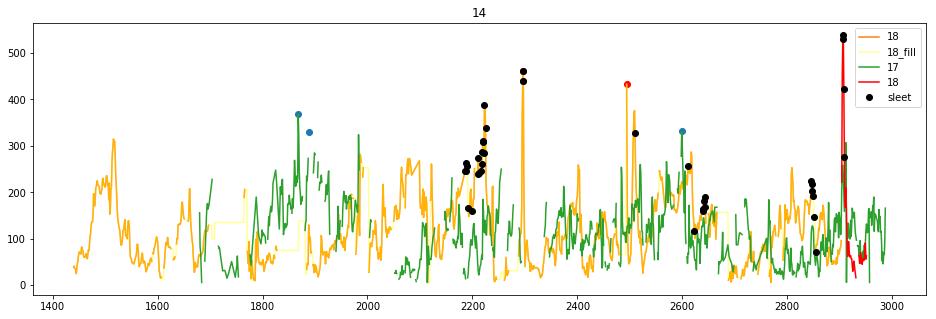

2017 ['2017-04-17 12:00:00' '2017-04-17 14:00:00' '2017-04-12 12:00:00']
2018 [['2018-04-05 16:00:00' 'CLEAR_NIGHT' 4.0 3.5256752247868137]
 ['2018-04-05 15:00:00' 'CLEAR_NIGHT' 7.0 3.5256752247868137]
 ['2018-04-05 17:00:00' 'HAZE' 4.0 3.5256752247868137]]
1
tongzhou_aq


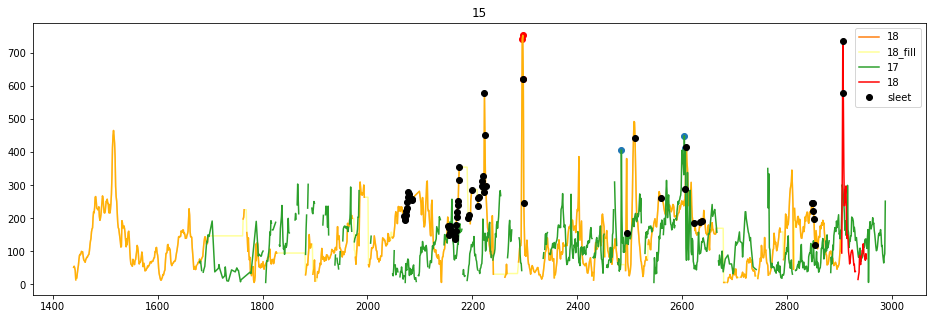

2017 ['2017-04-17 05:00:00' '2017-04-17 09:00:00' '2017-04-17 08:00:00']
2018 [['2018-04-05 16:00:00' 'Sunny/clear' 6.4 3.3859518495315983]
 ['2018-04-14 12:00:00' 'Sunny/clear' 16.6 3.3859518495315983]
 ['2018-04-14 10:00:00' 'Sunny/clear' 17.5 3.3859518495315983]]
1
shunyi_aq


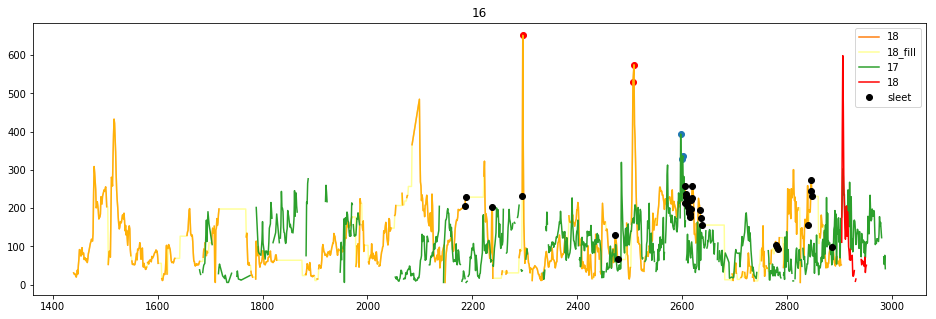

2017 ['2017-04-17 08:00:00' '2017-03-17 00:00:00' '2017-04-17 04:00:00']
2018 [['2018-03-28 11:00:00' nan nan 6.251167441225725]
 ['2018-04-05 15:00:00' 'Hail' 6.5 1.711654288777645]
 ['2018-04-30 23:00:00' 'Hail' 17.8 1.711654288777645]]
1
pingchang_aq


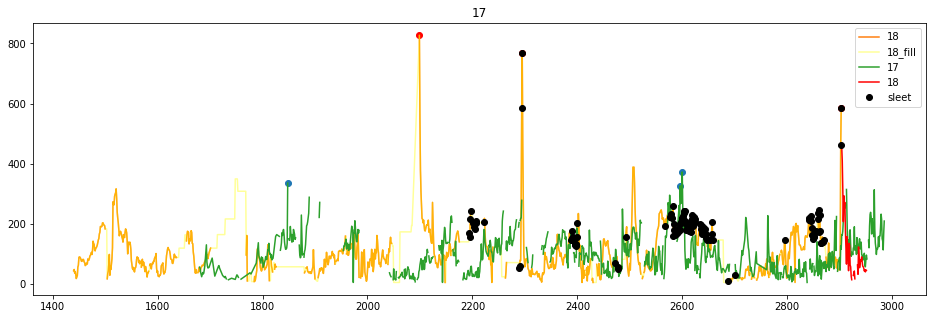

2017 ['2017-04-17 07:00:00' '2017-03-18 13:00:00' '2017-04-17 09:00:00']
2018 [['2018-04-13 20:00:00' 'CLEAR_NIGHT' 8.28 4.1401256112707125]
 ['2018-03-28 11:00:00' nan nan 7.013899971198461]
 ['2018-04-05 16:00:00' 'HAZE' 4.0 4.1401256112707125]]
1
mentougou_aq


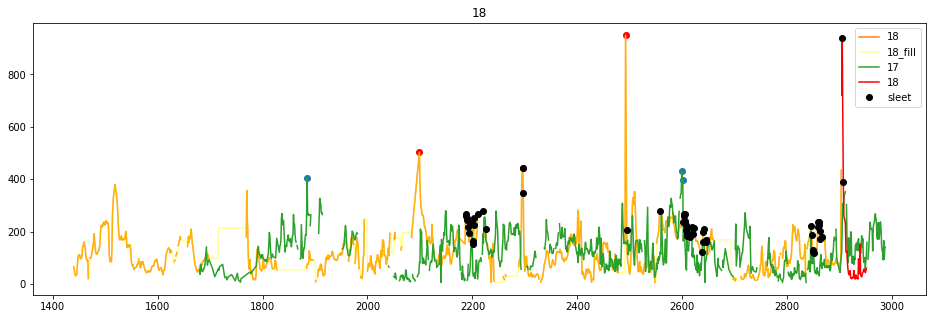

2017 ['2017-04-17 14:00:00' '2017-04-12 11:00:00' '2017-04-17 11:00:00']
2018 [['2018-03-04 05:00:00' nan 6.25 4.774589640836008]
 ['2018-04-05 16:00:00' 'Hail' 5.6 3.3039647928895244]
 ['2018-03-28 11:00:00' nan nan 6.329162018926981]]
1
pinggu_aq


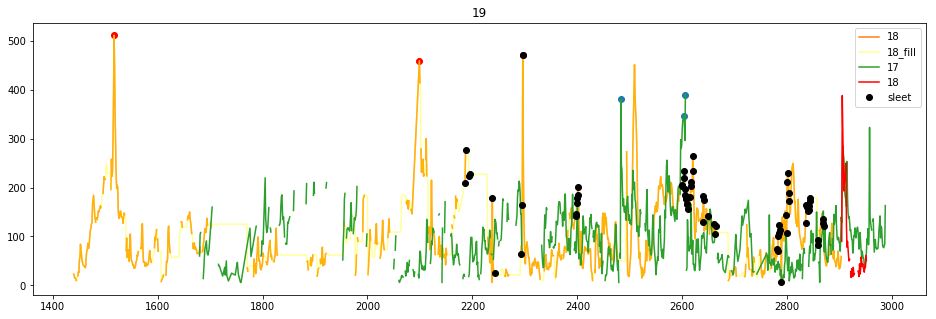

2017 ['2017-04-17 09:00:00' '2017-04-17 10:00:00' '2017-04-17 08:00:00']
2018 [['2018-04-05 15:00:00' 'Hail' 6.2 3.307777112207898]
 ['2018-03-28 11:00:00' nan nan 6.864575719205277]
 ['2018-03-28 12:00:00' nan nan 6.864575719205277]]
1
huairou_aq


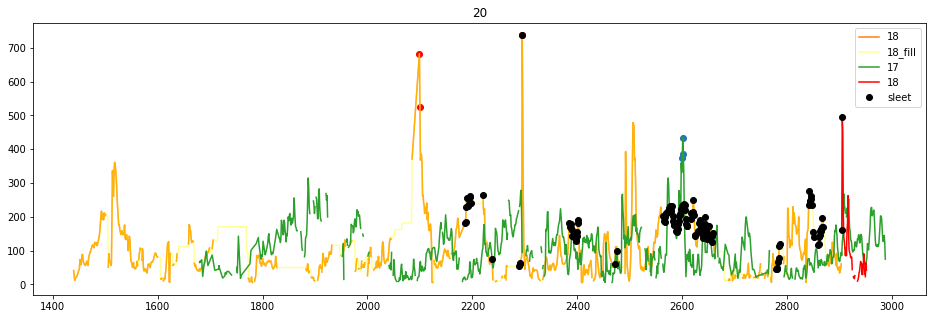

2017 ['2017-04-17 08:00:00' '2017-04-17 07:00:00' '2017-04-17 09:00:00']
2018 [['2018-03-27 21:00:00' nan nan 6.666095196153699]
 ['2018-03-28 11:00:00' nan nan 6.666095196153699]
 ['2018-04-14 12:00:00' 'Sleet' 15.6 2.855926618602037]]
1
miyun_aq


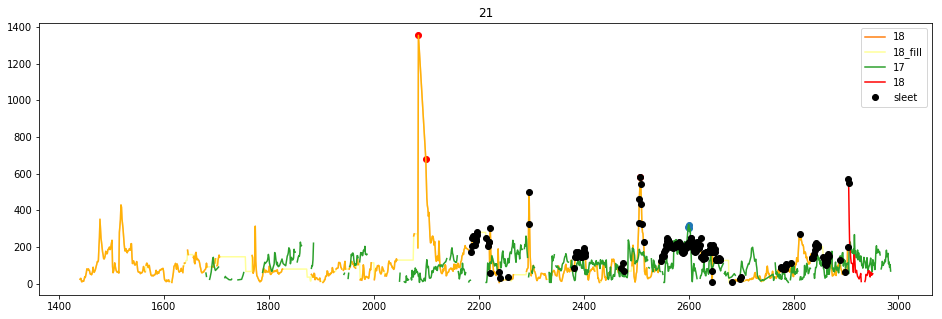

2017 ['2017-04-17 03:00:00' '2017-04-17 04:00:00' '2017-04-17 08:00:00']
2018 [['2018-03-02 20:00:00' nan -1.07 5.7337591688242275]
 ['2018-04-29 07:00:00' 'Hail' 29.7 0.4749035242445815]
 ['2018-03-28 11:00:00' nan nan 6.346825285843416]]
1
yanqin_aq


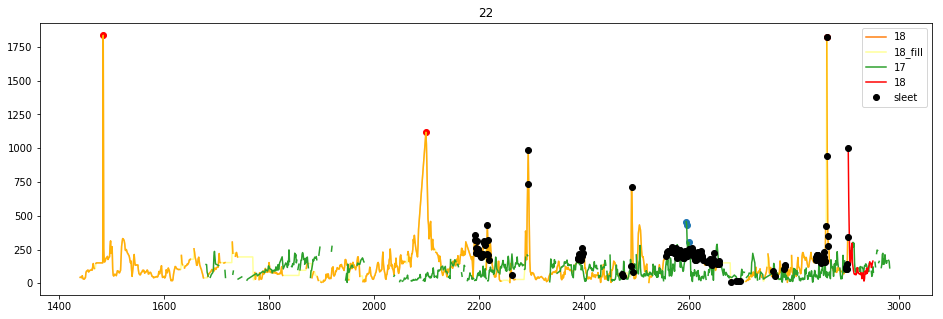

2017 ['2017-04-17 04:00:00' '2017-04-17 07:00:00' '2017-04-17 05:00:00']
2018 [['2018-03-27 21:00:00' 'Hail' 16.6 7.657605184753238]
 ['2018-03-27 20:00:00' 'Hail' 16.6 7.657605184753238]
 ['2018-03-29 12:00:00' 'Sunny/clear' 15.4 7.657605184753238]]
2
dingling_aq


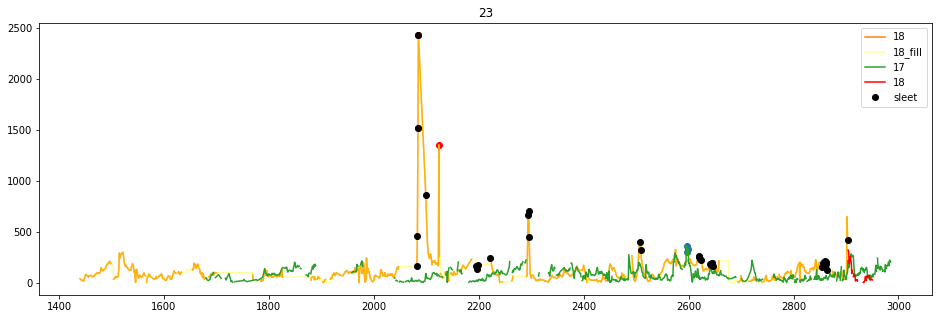

2017 ['2017-04-18 01:00:00' '2017-04-18 00:00:00' '2017-04-18 02:00:00']
2018 [['2018-04-29 06:00:00' 'HAZE' 30.0 4.017832594225799]
 ['2018-04-29 07:00:00' 'HAZE' 31.0 4.017832594225799]
 ['2018-04-13 19:00:00' 'PARTLY_CLOUDY_NIGHT' 5.82 4.017832594225799]]
2
badaling_aq


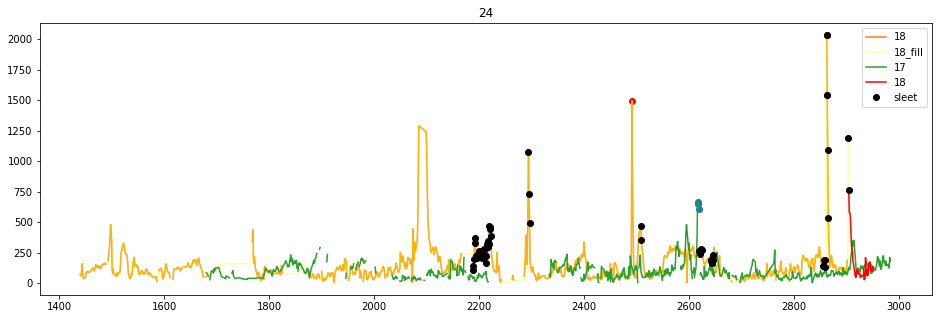

2017 ['2017-04-30 07:00:00' '2017-04-30 07:00:00' '2017-04-17 06:00:00']
2018 [['2018-04-05 15:00:00' 'CLEAR_NIGHT' 6.0 0.9390410760207668]
 ['2018-03-28 11:00:00' nan nan 9.409946210304124]
 ['2018-03-28 12:00:00' nan nan 9.409946210304124]]
2
miyunshuiku_aq


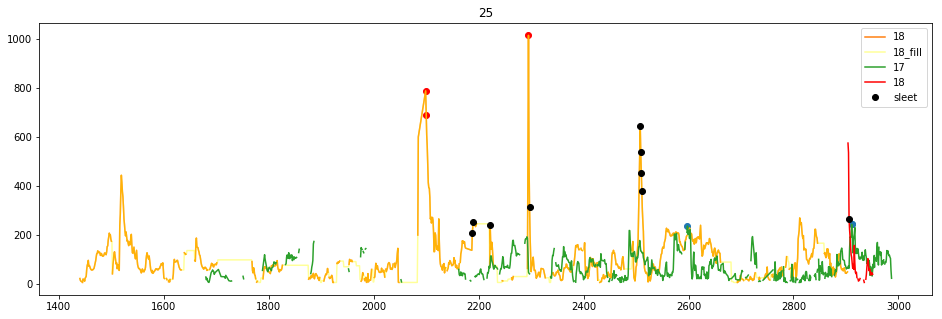

2017 ['2017-04-17 11:00:00' '2017-04-17 12:00:00' '2017-04-17 08:00:00']
2018 [['2018-03-04 05:00:00' nan 6.25 1.705383169474235]
 ['2018-04-14 14:00:00' 'HAZE' 15.0 1.705383169474235]
 ['2018-04-14 13:00:00' 'CLEAR_NIGHT' 15.0 1.705383169474235]]
2
donggaocun_aq


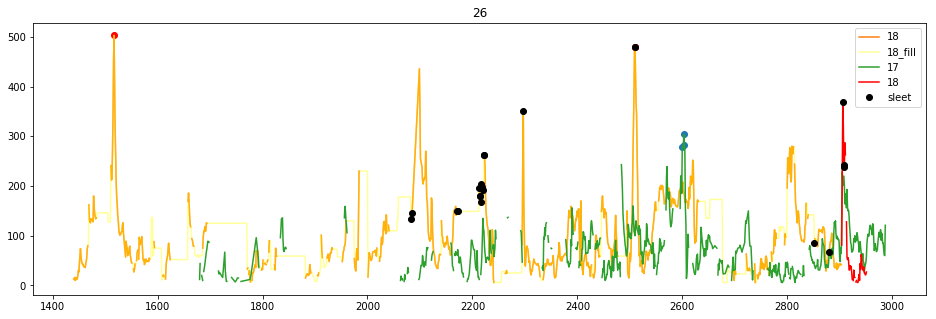

2017 ['2017-04-17 23:00:00' '2017-04-30 01:00:00' '2017-04-30 01:00:00']
2018 [['2018-03-24 23:00:00' nan 13.27 1.9750011659457618]
 ['2018-03-21 15:00:00' nan 6.62 1.9750011659457618]
 ['2018-04-14 12:00:00' 'CLEAR_NIGHT' 17.0 1.9750011659457618]]
2
yongledian_aq


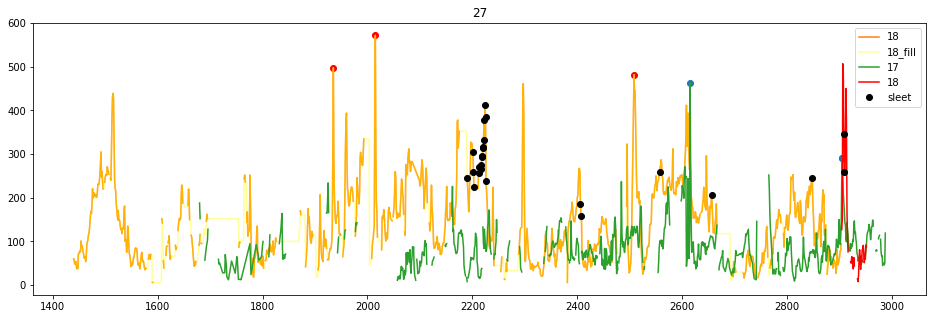

2017 ['2017-04-17 07:00:00' '2017-04-04 01:00:00' '2017-04-30 01:00:00']
2018 [['2018-04-02 15:00:00' 'HAZE' 17.0 2.220504628712349]
 ['2018-03-02 12:00:00' nan 7.59 2.220504628712349]
 ['2018-04-10 08:00:00' 'WIND' 23.0 2.220504628712349]]
2
yufa_aq


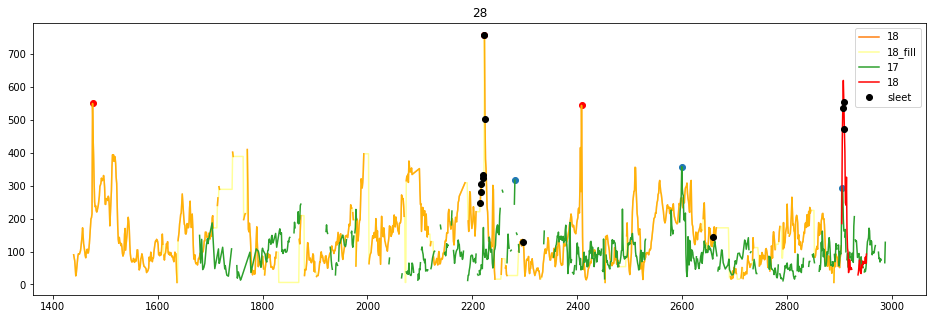

2017 ['2017-04-17 07:00:00' '2017-04-17 08:00:00' '2017-04-17 09:00:00']
2018 [['2018-04-02 16:00:00' 'HAZE' 17.0 2.2205352834159786]
 ['2018-03-02 13:00:00' nan 6.35 2.2205352834159786]
 ['2018-04-02 17:00:00' 'CLOUDY' 17.0 2.2205352834159786]]
2
liulihe_aq


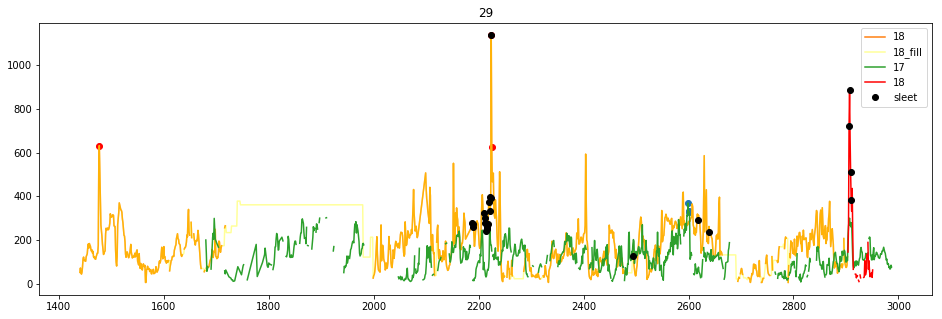

2017 ['2017-04-17 08:00:00' '2017-04-17 09:00:00' '2017-04-30 02:00:00']
2018 [['2018-04-05 16:00:00' 'CLEAR_NIGHT' 4.5 0.44177525743076973]
 ['2018-04-05 15:00:00' 'CLEAR_NIGHT' 7.0 0.44177525743076973]
 ['2018-04-05 14:00:00' 'CLEAR_NIGHT' 8.0 0.44177525743076973]]
3
qianmen_aq


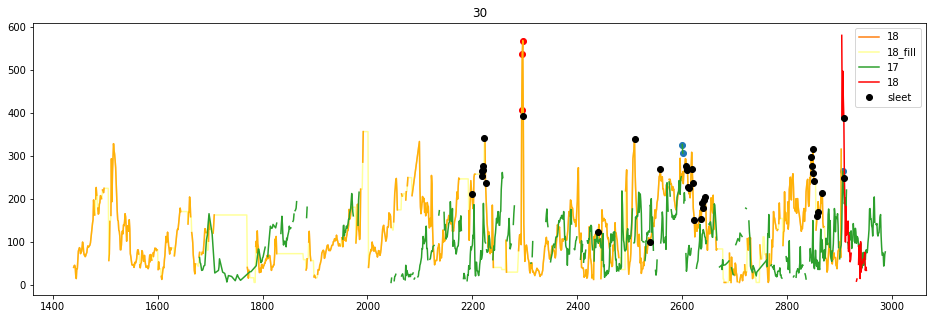

2017 ['2017-04-30 03:00:00' '2017-04-30 03:00:00' '2017-04-12 13:00:00']
2018 [['2018-04-05 16:00:00' 'CLEAR_NIGHT' 4.5 2.7137471279609118]
 ['2018-04-05 15:00:00' 'CLEAR_NIGHT' 7.0 2.7137471279609118]
 ['2018-04-02 16:00:00' 'CLOUDY' 14.0 2.7137471279609118]]
3
yongdingmennei_aq


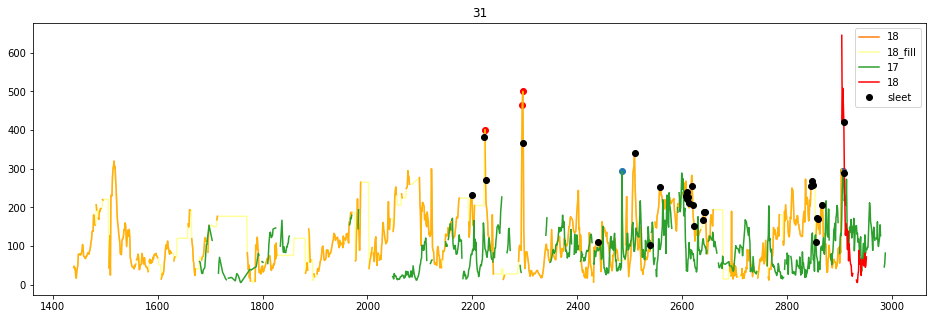

2017 ['2017-04-16 22:00:00' '2017-04-17 08:00:00' '2017-04-17 10:00:00']
2018 [['2018-04-05 16:00:00' 'Sunny/clear' 6.4 6.189518646240812]
 ['2018-04-05 15:00:00' 'Sunny/clear' 7.0 6.189518646240812]
 ['2018-03-28 11:00:00' nan nan 6.713181208407115]]
3
xizhimenbei_aq


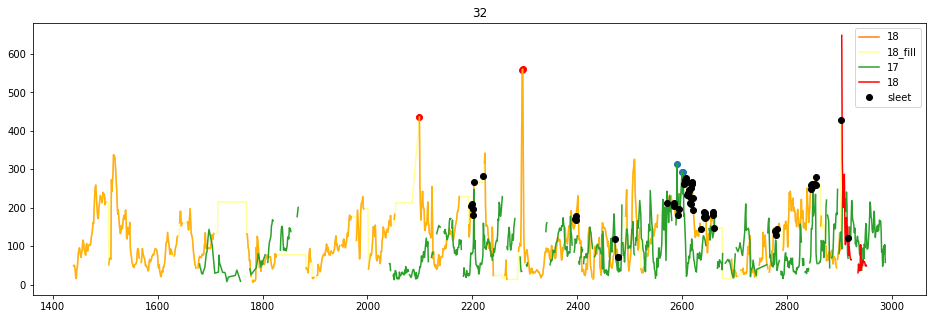

2017 ['2017-04-19 08:00:00' '2017-04-22 08:00:00' '2017-04-12 13:00:00']
2018 [['2018-04-10 04:00:00' 'WIND' 21.0 5.600091348749994]
 ['2018-04-05 16:00:00' 'CLEAR_NIGHT' 4.5 5.600091348749994]
 ['2018-04-05 17:00:00' 'HAZE' 4.4 5.600091348749994]]
3
nansanhuan_aq


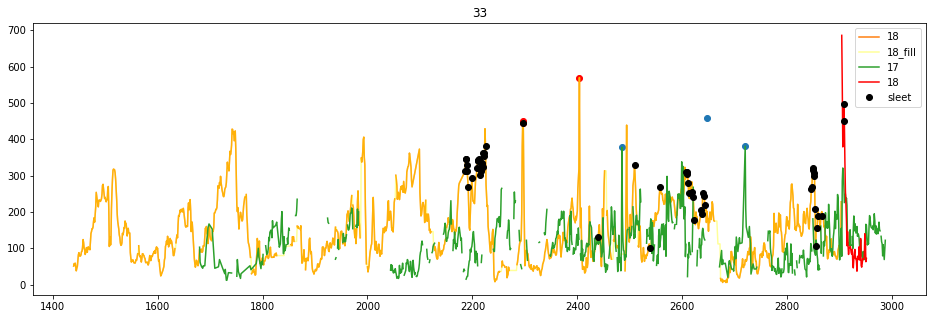

2017 ['2017-04-02 20:00:00' '2017-04-30 04:00:00' '2017-04-30 04:00:00']
2018 [['2018-04-05 16:00:00' 'Hail' 6.7 2.1376681396633805]
 ['2018-04-05 15:00:00' 'Hail' 7.6 2.1376681396633805]
 ['2018-04-23 08:00:00' 'Sunny/clear' 19.0 2.1376681396633805]]
3
dongsihuan_aq


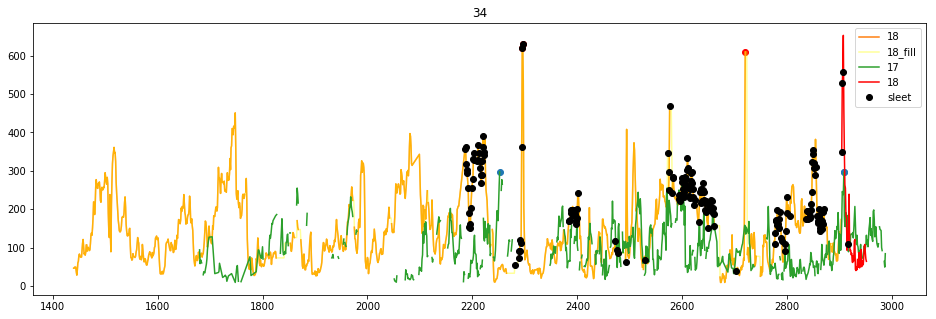

In [29]:
grouped = aq_2018.groupby('station_id_int')
attr_test = 'PM10'
for name,group in grouped:
    plt.figure(figsize=(16,5))
    
    #filter out extremly large value
    
    group = group.loc[(group.time < '2018-03-27 22:00:00') | (group.time > '2018-03-28 10:00:00')]
    
    #end of filter
    
    group = group.sort_values(by='date_h')
    group_train = group.loc[group.month != 5]
    group_test = group.loc[group.month == 5]
    group_2017 = aq_2017.loc[aq_2017.station_id_int == name]
    group_2017 = group_2017.sort_values(by='date_h')
    
    
    
    
    top3_2017 = group_2017.sort_values(by=attr_test,ascending=False)
    top3_2018 = group_train.sort_values(by=attr_test,ascending=False)
    print("2017",top3_2017['time'].values[:3])
    print("2018",top3_2018[['time','weather','temperature','dist']].values[:3])
    plt.plot(top3_2018.date_h.values[:3],top3_2018[attr_test].values[:3],'o',color='red')
    plt.plot(top3_2017.date_h.values[:3]+24,top3_2017[attr_test].values[:3],'o')
    #max_row_2017 = group_2017.ix[group_2017[attr_test].idxmax()]
    #print(max_row_2017.time)
    station_type_id = group_train.station_type_id.astype(np.int8).values[0]
    print(station_type_id)
    print(group_train.station_id.values[0])
    plt.title(name)
    plt.plot(group_train['date_h'].values,group_train[attr_test].values,label='18')
    plt.plot(group_train['date_h'].values,group_train[attr_test].fillna(method='ffill').values,label='18_fill',alpha=0.4,color='yellow')
    plt.plot(group_2017['date_h'].values+24,group_2017[attr_test].values,label='17')
    plt.plot(group_test['date_h'].values,group_test[attr_test].values,label='18',color='red')
    
    
    #plot the sleet part
    group_sleet = group.loc[group.weather.isin(['Sleet','HAZE','Hail'])]
    plt.plot(group_sleet['date_h'].values,group_sleet[attr_test].values,'o',color='black',label = 'sleet')
    
    
    plt.legend()
    plt.show()

findings:1.恶略天气PM10一般很高，也跟恶略天气持续的时间有关，例如持续了10个小时之后会有所下降<br> 2.17年的数据看起来没有太大参考意义并且缺失值很多

In [26]:
weather_all.head()

,index,humidity,id,pressure,station_id,temperature,time,weather,wind_direction,wind_speed
0,0,51.0,2028533,1009.2,shunyi_meo,15.5,2018-04-01 01:00:00,Hail,82.0,0.5
1,1,51.0,2028534,1006.8,hadian_meo,15.7,2018-04-01 01:00:00,Hail,50.0,1.8
2,2,33.0,2028535,955.6,yanqing_meo,12.6,2018-04-01 01:00:00,Hail,34.0,0.8
3,3,40.0,2028536,1004.0,miyun_meo,14.8,2018-04-01 01:00:00,Hail,999017.0,0.2
4,4,44.0,2028537,1003.4,huairou_meo,15.3,2018-04-01 01:00:00,Hail,146.0,1.5


In [108]:
bad_view = weather_all.loc[weather_all.weather == 'Sleet'].time.unique()